# EDF Files Combination

By: Adam Li

3/26/19: In order to allow facilitation of preprocessing of edf files into fif+json pairs, certain edf files need to be either split, or they need to be combined into one file in order to facilitate further downstream analysis.

E.g.
- EDF file with multiple seizures -> {edf_file01, edf_file02, ...}
- one seizure split into multiple edf files -> {edf_file}



In [1]:
import pyedflib # pip install pyedflib
from datetime import datetime
import mne
import os
import sys
import numpy as np

sys.path.append('../../')

import eztrack
from eztrack.edp.format.formatter_raw import ConvertEDFiEEG
from eztrack.edp.loaders.dataset.timeseries.ieegrecording import iEEGRecording
from eztrack.edp.format.formatter_raw import ConvertEDFiEEG

import matplotlib.pyplot as plt
import seaborn as sns
import timeit
# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2

In [74]:
def write_edf(mne_raw, fname, events_list, picks=None, tmin=0, tmax=None, overwrite=False):
    """
    Saves the raw content of an MNE.io.Raw and its subclasses to
    a file using the EDF+ filetype
    pyEDFlib is used to save the raw contents of the RawArray to disk
    Parameters
    ----------
    mne_raw : mne.io.Raw
        An object with super class mne.io.Raw that contains the data
        to save
    fname : string
        File name of the new dataset. This has to be a new filename
        unless data have been preloaded. Filenames should end with .edf
    picks : array-like of int | None
        Indices of channels to include. If None all channels are kept.
    tmin : float | None
        Time in seconds of first sample to save. If None first sample
        is used.
    tmax : float | None
        Time in seconds of last sample to save. If None last sample
        is used.
    overwrite : bool
        If True, the destination file (if it exists) will be overwritten.
        If False (default), an error will be raised if the file exists.
    """
    if not issubclass(type(mne_raw), mne.io.BaseRaw):
        raise TypeError('Must be mne.io.Raw type')
    if not overwrite and os.path.exists(fname):
        raise OSError('File already exists. No overwrite.')
    # static settings
    file_type = pyedflib.FILETYPE_EDFPLUS
    sfreq = mne_raw.info['sfreq']
    date = datetime.now().strftime('%d %b %Y %H:%M:%S')
    first_sample = int(sfreq * tmin)
    last_sample = int(sfreq * tmax) if tmax is not None else None

    # convert data
    channels = mne_raw.get_data(picks,
                                start=first_sample,
                                stop=last_sample)

    # convert to microvolts to scale up precision
    channels *= 1e6

    # set conversion parameters
    dmin, dmax = [-32768, 32767]
    pmin, pmax = [channels.min(), channels.max()]
    n_channels = len(channels)

    # create channel from this
    try:
        f = pyedflib.EdfWriter(fname,
                               n_channels=n_channels,
                               file_type=file_type)

        channel_info = []
        data_list = []

        for i in range(n_channels):
            ch_dict = {'label': mne_raw.ch_names[i],
                       'dimension': 'uV',
                       'sample_rate': sfreq,
                       'physical_min': pmin,
                       'physical_max': pmax,
                       'digital_min': dmin,
                       'digital_max': dmax,
                       'transducer': '',
                       'prefilter': ''}
#             print(ch_dict)
            channel_info.append(ch_dict)
            data_list.append(channels[i])

        f.setTechnician('mne_save_edf_adamli')
        f.setSignalHeaders(channel_info)
        for event in events_list:
            onset_in_seconds, duration_in_seconds, description = event
            print(onset_in_seconds, duration_in_seconds, description)
            f.writeAnnotation(float(onset_in_seconds), int(duration_in_seconds), description)
        f.setStartdatetime(date)
        f.writeSamples(data_list)
    except Exception as e:
        print(e)
        return False
    finally:
        f.close()
    return True

In [130]:
from eztrack.edp.format.formatter_raw import ConvertEDFiEEG
from eztrack.edp.utils.utils import writejsonfile

class CombineEDF():
    def __init__(self, edffiles, dataset_id):
        self.filelist = edffiles
        self.dataset_id = dataset_id
            
        self.metadata_list = []
        self.rawfif_list = []
        
    def load_files(self):
        for edffile in self.filelist:
            # initialize converter
            edfconverter = ConvertEDFiEEG(datatype='ieeg')
            # load in the dataset and create metadata object
            edfconverter.load_file(filepath=edffile)

            # load in info data structure and edf annotated events
            edfconverter.extract_info_and_events(pat_id=patid)
            rawfif = edfconverter.convert_fif(bad_chans_list=[], save=False, replace=False)
            metadata = edfconverter.convert_metadata(patid, dataset_id, center, save=False)
            self.metadata_list.append(metadata)
            self.rawfif_list.append(rawfif)
            self.samplerate = rawfif.info['sfreq']
    
    def combine_datasets(self):
        print(self.rawfif_list)
        # combine and append the datasets
        for idx, dataset in enumerate(self.rawfif_list):
            if idx == 0:
                combined_dataset = dataset
            else:
                combined_dataset.append(dataset)

        print("Combined dataset: ", combined_dataset)
        self.samplerate = combined_dataset.info['sfreq']
        return combined_dataset
            
    def combine_metadata(self):
        for idx, metadata in enumerate(self.metadata_list):
            if idx == 0:
                combined_metadata = metadata
            else:
                combined_metadata = self._update_dict(
                    combined_metadata, metadata)
        return combined_metadata
    
    def _update_dict(self, master_dict, appendage_dict):
        TIME_DEPENDENT_KEYS = ['length_of_recording',
                               'events', 
                               'onset', 
                               'termination']

        prevlen = master_dict['length_of_recording']
        # samplerate = master_dict['samplerate']
        samplerate = self.samplerate
        prevsec = self._convert_sec(prevlen, samplerate)

        # print("Lengths of recordings: ", prevlen, samplerate, prevsec)
        for key in appendage_dict.keys():
            if key in TIME_DEPENDENT_KEYS:
                if key == 'length_of_recording':
                    master_dict[key] = appendage_dict[key] + prevlen
                elif key == 'onset' or key == 'termination':
                    master_dict[key] = appendage_dict[key] + prevsec
                elif key == 'events':
                    master_dict[key] = self._concat_events(master_dict[key],
                                                           appendage_dict[key],
                                                           prevsec)
            if key not in master_dict.keys():
                master_dict[key] = appendage_dict[key]

        return master_dict

    def _convert_sec(self, index, samplerate):
        return np.divide(index, samplerate)

    def _concat_events(self, events_list, new_events, recording_length_seconds):
#         print(events_list.shape)
#         print(new_events.shape)
        for event in new_events:
            # print(event.shape)
            new_event = event
            new_event[0] = float(new_event[0]) + recording_length_seconds
            events_list = np.concatenate(
                (events_list, np.expand_dims(new_event, axis=0)), axis=0)

#         print(recording_length_seconds)
#         print(events_list)
        return events_list
    
    def save_fif(self, fif_raw, dataset_metadata, datafilepath, replace=False):
        """
        Conversion function for the rawdata + metadata into a .fif file format with accompanying metadata .json
        object.

        rawdata + metadata_dict -> .fif + .json

        :param newfilepath:
        :param dataset_metadata:
        :param replace:
        :return:
        """
        # create a new information structure
        rawdata = fif_raw.get_data(return_times=False)
        assert rawdata.shape[0] == dataset_metadata['number_chans']

        fif_raw.save(datafilepath,
                     overwrite=replace,
                     verbose='ERROR')

        # create a filepath for the json object
        dataset_metadata['filename'] = os.path.basename(datafilepath)
        newmetafilepath = datafilepath.replace('_raw.fif', '.json')

        # save the formatted metadata json object
        writejsonfile(dataset_metadata, newmetafilepath, overwrite=replace)


## Data Directories

In [157]:
center = 'cleveland'
patid = 'la13'
modality = 'seeg'
dataset_id = 'sz_1'

patdir = os.path.join(f"/Users/adam2392/Downloads/tngpipeline/{center}/{patid}/{modality}/edf/")
patdir = os.path.join(f"/home/adam2392/hdd/data/rawdata/{center}/{patid}/{modality}/edf/")
datadir = os.path.join(patdir, f"combine/{dataset_id}")

edffiles = sorted([os.path.join(datadir,f) for f in os.listdir(datadir) if f.endswith('.edf')])

print(edffiles)

['/home/adam2392/hdd/data/rawdata/cleveland/la13/seeg/edf/combine/sz_1/la13_ictal_1.edf', '/home/adam2392/hdd/data/rawdata/cleveland/la13/seeg/edf/combine/sz_1/la13_ictal_2.edf', '/home/adam2392/hdd/data/rawdata/cleveland/la13/seeg/edf/combine/sz_1/la13_ictal_3.edf', '/home/adam2392/hdd/data/rawdata/cleveland/la13/seeg/edf/combine/sz_1/la13_ictal_4.edf']


In [158]:
combiner = CombineEDF(edffiles, dataset_id)

# load all the files
combiner.load_files()

Extracted onset and offset as:  [] []
la13 sz_1
 la13_ictal_1.edf
Extracted onset and offset as:  [] []
la13 sz_1
 la13_ictal_2.edf


../../eztrack/edp/format/formatter_raw.py:86: UserWarning: Hmm the bad channels you specify are not the ones you sent into the .fif dataset?
  "Hmm the bad channels you specify are not the ones you sent into the .fif dataset?")
../../eztrack/edp/format/formatter_raw.py:86: UserWarning: Hmm the bad channels you specify are not the ones you sent into the .fif dataset?
  "Hmm the bad channels you specify are not the ones you sent into the .fif dataset?")


Extracted onset and offset as:  [] []
la13 sz_1
 la13_ictal_3.edf


../../eztrack/edp/format/formatter_raw.py:86: UserWarning: Hmm the bad channels you specify are not the ones you sent into the .fif dataset?
  "Hmm the bad channels you specify are not the ones you sent into the .fif dataset?")


Extracted onset and offset as:  120.099 147.485
la13 sz_1
 la13_ictal_4.edf


../../eztrack/edp/format/formatter_raw.py:86: UserWarning: Hmm the bad channels you specify are not the ones you sent into the .fif dataset?
  "Hmm the bad channels you specify are not the ones you sent into the .fif dataset?")


In [159]:
# combine metadata
combined_metadata = combiner.combine_metadata()
combined_rawfif = combiner.combine_datasets()

[<RawArray  |  None, n_channels x n_times : 99 x 159000 (159.0 sec), ~120.3 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 99 x 11000 (11.0 sec), ~8.5 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 99 x 120000 (120.0 sec), ~90.8 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 99 x 421000 (421.0 sec), ~318.2 MB, data loaded>]
Combined dataset:  <RawArray  |  None, n_channels x n_times : 99 x 711000 (711.0 sec), ~537.2 MB, data loaded>


In [160]:
combined_rawfif.drop_channels([
    "sti014",
#                                "events/markers", 
                               "mark1", "mark2"])

<RawArray  |  None, n_channels x n_times : 96 x 711000 (711.0 sec), ~520.9 MB, data loaded>

In [161]:
print(np.unique(combined_rawfif.ch_names))

['dc01' 'dc02' 'dc03' 'dc04' 'dc05' 'dc06' 'e' 'ekg1' 'ekg2'
 'events/markers' 'lf1' 'lf2' 'q1' 'q2' 'q3' 'q4' 'q5' 'q6' 'q7' 'q8' 'r1'
 'r10' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8' 'r9' 'ref1' 'ref2' 's1' 's10'
 's11' 's12' 's13' 's14' 's15' 's16' 's2' 's3' 's4' 's5' 's6' 's7' 's8'
 's9' 't1' 't10' 't2' 't3' 't4' 't5' 't6' 't7' 't8' 't9' 'u1' 'u10' 'u11'
 'u12' 'u2' 'u3' 'u4' 'u5' 'u6' 'u7' 'u8' 'u9' 'x1' 'x10' 'x2' 'x3' 'x4'
 'x5' 'x6' 'x7' 'x8' 'x9' 'y1' 'y10' 'y11' 'y12' 'y13' 'y14' 'y15' 'y16'
 'y2' 'y3' 'y4' 'y5' 'y6' 'y7' 'y8' 'y9']


In [162]:
print(len(combined_rawfif.ch_names))
print(combined_rawfif.ch_names)
# print(combiner.rawfif_list[0].info)

print(combiner.rawfif_list)

96
['x1', 'x2', 'x3', 'x4', 'ref1', 'ref2', 'x5', 'x6', 'x7', 'x8', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 'e', 's10', 's11', 'x9', 'x10', 's12', 's13', 's14', 's15', 's16', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'dc01', 'dc02', 'dc03', 'dc04', 'dc05', 'dc06', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8', 'u9', 'u10', 'u11', 'u12', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 'lf1', 'lf2', 'ekg1', 'ekg2', 'events/markers']
[<RawArray  |  None, n_channels x n_times : 96 x 711000 (711.0 sec), ~520.9 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 99 x 11000 (11.0 sec), ~8.5 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 99 x 120000 (120.0 sec), ~90.8 MB, data loaded>, <RawArray  |  None, n_channels x n_times : 99 x 421000 (421.0 sec), ~318.2 MB, data loaded>]

In [163]:
rawdata = combined_rawfif.get_data()
print(rawdata.shape)

(96, 711000)


In [164]:
print(combined_rawfif.ch_names[0])
ch = rawdata[0,:]
print(ch[5000:5050])
print(combiner.rawfif_list[2])

if patid == 'la13':
    combined_rawfif.drop_channels([
            "s3",
            "s4",
            "s5",
            "s6",
            "s7",
            "s8",
            "s9",
            "s10",
            "s11",
            "y5",
            "y6",
            "y11",
            "y12",
            "u2",
#             "ref1",
#             "ref2",
            "dc01",
            "dc02",
            "dc03",
            "dc04",
            "dc05",
            "dc06",
            "e",
#             "ekg1",
        ])
elif patid == 'la07':
    combined_rawfif.drop_channels([
#          "t'9",
#         "t'10",
#         "u'10",
#         "x'3",
#         "x'4",
#         "x'5",
#         "x'6",
#         "x'7",
#         "x'8",
#         "x'9",
#         "x'10",
#         "x'16",
#         "s'1",
#         "s'2",
#         "s'7",
#         "s'8",
#         "r'1",
#         "o'6",
#         "o'7",
#         "o'8",
#         "o'11",
#         "y'7",
#         "y'8",
#         "z'5",
#         "z'6",
#         "z'7",
#         "z'8",
#         "z'9",
#         "z'10",
#         "ref1",
#         "ref2",
        "dc01",
        "dc02",
        "dc03",
        "dc04",
        "dc05",
        "dc06",
        "e"
    ])
# print(combiner.rawfif_list[2].info)

x1
[-2.95900140e-05 -2.98829828e-05 -2.97853265e-05 -2.95900140e-05
 -2.85157953e-05 -2.89064203e-05 -2.86134516e-05 -2.81251704e-05
 -2.67579829e-05 -2.71486079e-05 -2.67579829e-05 -2.59767330e-05
 -2.50001705e-05 -2.63673580e-05 -2.42189206e-05 -2.48048580e-05
 -2.33400144e-05 -2.41212643e-05 -2.33400144e-05 -2.33400144e-05
 -2.31447019e-05 -2.44142331e-05 -2.38282956e-05 -2.47072018e-05
 -2.45118893e-05 -2.53907955e-05 -2.53907955e-05 -2.70509517e-05
 -2.59767330e-05 -2.71486079e-05 -2.69532954e-05 -2.60743892e-05
 -2.59767330e-05 -2.66603267e-05 -2.53907955e-05 -2.56837642e-05
 -2.50001705e-05 -2.63673580e-05 -2.61720455e-05 -2.68556392e-05
 -2.67579829e-05 -2.78322016e-05 -2.64650142e-05 -2.77345454e-05
 -2.75392329e-05 -2.85157953e-05 -2.87111078e-05 -3.00782953e-05
 -3.02736078e-05 -3.10548577e-05]
<RawArray  |  None, n_channels x n_times : 99 x 120000 (120.0 sec), ~90.8 MB, data loaded>


(75, 711000)


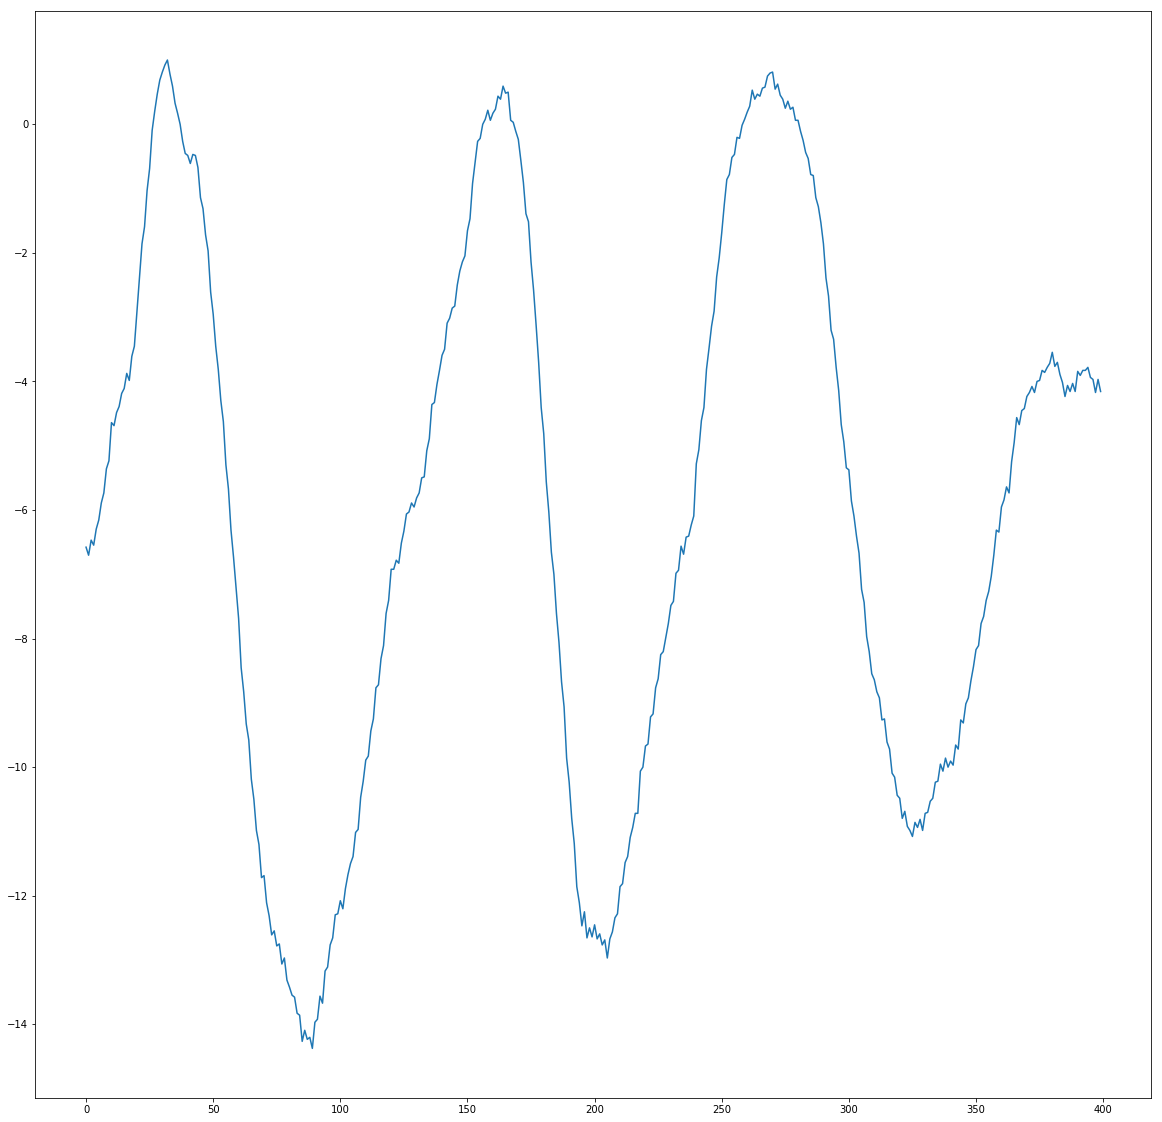

In [165]:
rawdata = combined_rawfif.get_data()
print(rawdata.shape)

fig, ax = plt.subplots(1,1, figsize=(20,20))
for i in range(len(combined_rawfif.ch_names)):
    ax.plot(np.r_[i]+rawdata[i,20000:20400] / max(rawdata[i,20000:20400]))
    break

# Write Combined FIF Into Another EDF File

In [166]:
fname = os.path.join(patdir, f"{patid}_{dataset_id}.edf")
events_list = combined_metadata['events']

write_edf(combined_rawfif, fname, events_list, picks=None, 
          tmin=0, tmax=None, overwrite=True)

0.0 0 REC START Tech-Bi CA
1.16 0 A1+A2 OFF           
3.32 0 PAT Tech-Bi EEG     
128.513 0 SPK                 
159.0 0 REC START Tech-Bi EE
159.0 0 A1+A2 OFF           
170.0 0 REC START Tech-Bi EE
171.1 0 A1+A2 OFF           
290.0 0 REC START Tech-Bi EE
290.0 0 A1+A2 OFF           
408.881 0 note emgs           
410.099 0 SZ 8P               
420.58500000000004 0 Clin Onset          
432.38 0 MARK ON             
436.108 0 alerts and clinical 
437.36 0 MARK OFF            
437.485 0 No clear EEG offset 


True

In [167]:
rawedf = mne.io.read_raw_edf(fname, preload=True)

print(rawedf)

Extracting EDF parameters from /home/adam2392/hdd/data/rawdata/cleveland/la13/seeg/edf/la13_sz_1.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 710999  =      0.000 ...   710.999 secs...
Used Annotations descriptions: ['REC START Tech-Bi CA', 'A1+A2 OFF           ', 'PAT Tech-Bi EEG     ', 'SPK                 ', 'REC START Tech-Bi EE', 'note emgs           ', 'SZ 8P               ', 'Clin Onset          ', 'MARK ON             ', 'alerts and clinical ', 'MARK OFF            ', 'No clear EEG offset ']
<RawEDF  |  la13_sz_1.edf, n_channels x n_times : 76 x 711000 (711.0 sec), ~412.4 MB, data loaded>


In [168]:
rawdata = rawedf.get_data()
print(rawdata.shape)
# print(min(rawdata.flatten()), max(rawdata.flatten()))

(76, 711000)


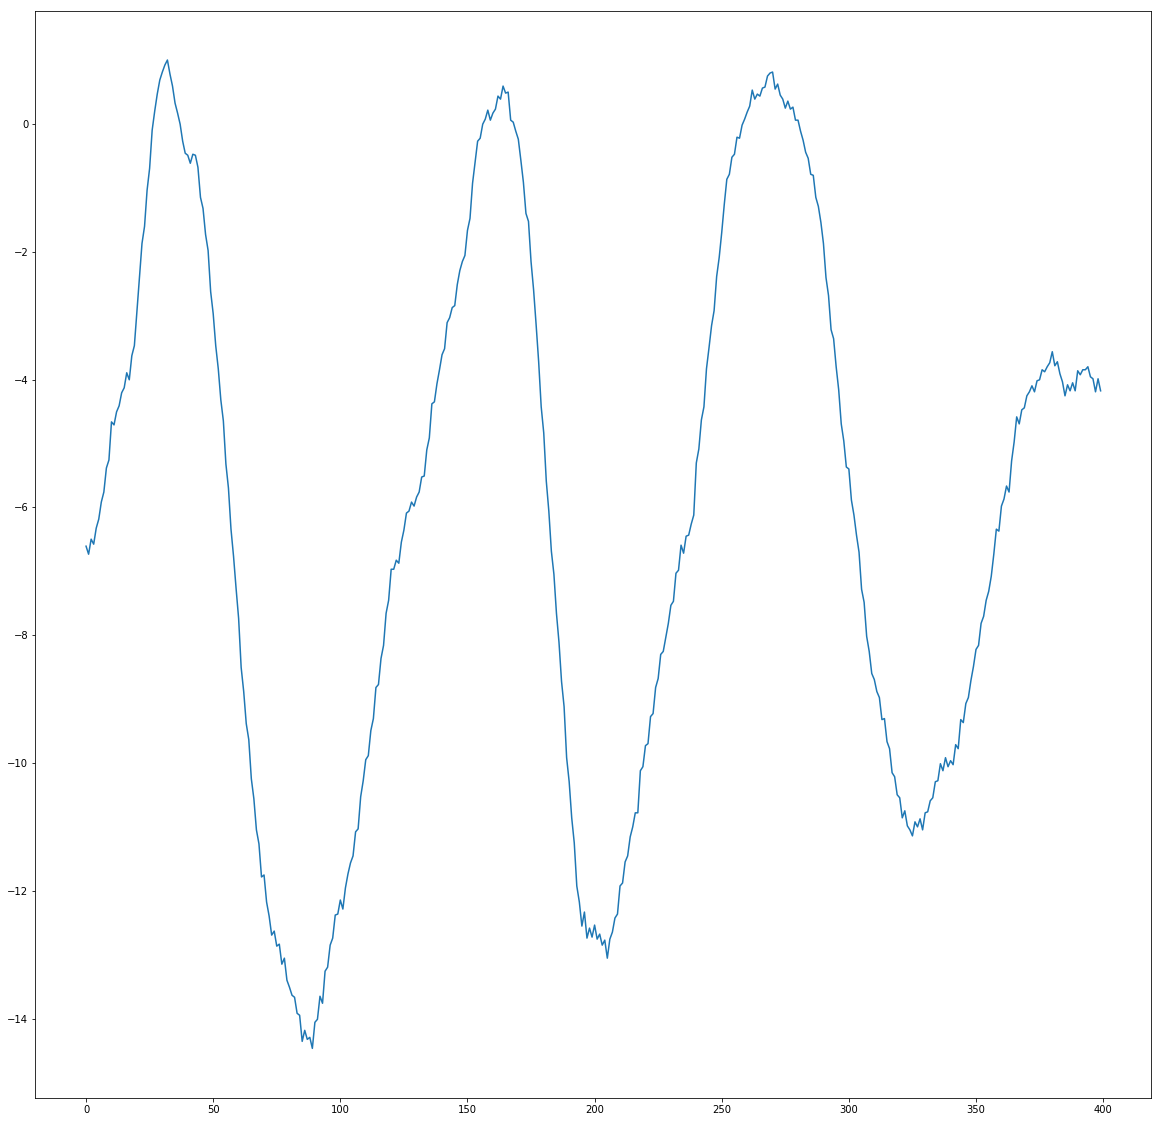

In [169]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
for i in range(len(combined_rawfif.ch_names)):
    ax.plot(np.r_[i]+rawdata[i,20000:20400] / max(rawdata[i,20000:20400]))
    
    break
#     if i == 10:
#         break